In [1]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

# Perform a basic 'inverse' calculation

Using ATM you can also perform inversion calculations to derive various outputs using emission intensities as inputs.

This function works very similarly to the 'forward' function, where-by some inputs are required, some are optional, and outputs are enabled using True/False flags as part of the request.

Please note that the limitations on latitude and longitude range are designed to constraint request to the targeted region that the TREx optical instrumentation are deployed to. We also note that the model only takes into account data when the optical instruments were operating at 105 degrees solar zenith angle, which is several degrees lower than nominal data acquisition. This ultimately means that the beginning and end of each night have been excluded when deriving the model algorithm.

Full documentation on this function is [in the `inverse()` function documentation](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax/models/atm/index.html#pyaurorax.models.atm.ATMManager.inverse).

<small>
Input notes:

- timestamp is limited to a set of years
  - if you supply a request outside of this valid range, an exception will be raised
  - 2019-2023 as of June 2024, more will be added
- latitude and longitude
  - are to be in geodetic coordinates
  - latitude is currently limited to &ge;50.0 and &lt;61.5 degrees
  - longitude is currently limited &ge;-110 and &lt;-70 and degrees
- valid values for nrlmsis_model_version are '00' and '2.0'
- valid values for precipitation_flux_spectral_type are 'gaussian' and 'maxwellian'
- intensity parameters are expected to be in Rayleighs
</small>

<small>
Output notes:

- output parameter of the request are toggles the enable/disable each field's inclusion in the response
- all output parameters are false by default
- altitude is in kilometers
- energy flux: erg/cm2/s
- characteristic energy: eV
- emission data: 1-D array -- volume emission rate (1/cm^3/s)
- plasma electron density: 1-D array -- density (cm^-3)
- plasma O2+ density: 1-D array -- density (cm^-3)
- plasma NO+ density: 1-D array -- density (cm^-3)
- plasma O+ density: 1-D array -- density (cm^-3)
- plasma ionisation rate: 1-D array -- ionisation rate (1/cm^3/s)
- plasma electron temperature: 1-D array -- temperature (K)
- plasma ion temperature: 1-D array -- temperature (K)
- plasma peterson conductivity: 1-D array -- conductivity (S/m)
- plasma hall conductivity: 1-D array -- conductivity (S/m)
- neutral O2 density: 1-D array -- density (cm^-3)
- neutral O density: 1-D array -- density (cm^-3)
- neutral N2 density: 1-D array -- density (cm^-3)
- neutral N density: 1-D array -- density (cm^-3)
- neutral temperature: 1-D array -- temperature (K)
</small>

Exactly like the 'forward' calculations, ATM inverse requests work in a way where you toggle ON whatever outputs you want back. This allows you to get back only what you want. This mechanism is controlled by the `ATMInverseOutputFlags()` class that must be instantiated before making the calculation.

As part of this class, there are helper functions that toggle all ON or OFF.

In [2]:
# set up our request
#
# just like the forward function, outputs are toggled on/off using a flag object.
timestamp = datetime.datetime(2021, 10, 12, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

intensity_4278 = 2302.6
intensity_5577 = 11339.5
intensity_6300 = 528.3
intensity_8446 = 427.4

output = pyaurorax.models.ATMInverseOutputFlags()
output.energy_flux = True
output.characteristic_energy = True
output.oxygen_correction_factor = True

In [3]:
# perform the calculation
result = aurorax.models.atm.inverse(timestamp, latitude, longitude, intensity_4278, intensity_5577, intensity_6300, intensity_8446, output)

# let's view the output values we asked for
print("Energy Flux:                %.03f erg/cm2/s" % (result.energy_flux))
print("Characteristic Energy:      %.03f eV" % (result.characteristic_energy))
print("Oxygen Correction Factor:   %.03f" % (result.oxygen_correction_factor))


Energy Flux:                9.026 erg/cm2/s
Characteristic Energy:      4659.787 eV
Oxygen Correction Factor:   0.529


In [4]:
# you can see a nice print of the returned data using the pretty_print() function
result.pretty_print()

ATMInverseResult:
  altitudes                            : None
  characteristic_energy                : 4659.787109
  emission_4278                        : None
  emission_5577                        : None
  emission_6300                        : None
  emission_8446                        : None
  energy_flux                          : 9.026382
  height_integrated_rayleighs_4278     : None
  height_integrated_rayleighs_5577     : None
  height_integrated_rayleighs_6300     : None
  height_integrated_rayleighs_8446     : None
  neutral_n2_density                   : None
  neutral_n_density                    : None
  neutral_o2_density                   : None
  neutral_o_density                    : None
  neutral_temperature                  : None
  oxygen_correction_factor             : 0.528542
  plasma_electron_density              : None
  plasma_electron_temperature          : None
  plasma_hall_conductivity             : None
  plasma_ion_temperature               : None
 

# Inverse calculation and include all output parameters

You can also do a request and specify the output flags to return everything that the ATM 'inverse' endpoint has to offer. Below, we're going to do that and plot all data.

For this request, we're going to also change the precipitation flux spectral type to maxwellian, to illustrate that either 'gaussian' or 'maxwellian' can be used.


In [5]:
# set up parameters
timestamp = datetime.datetime(2021, 10, 12, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

intensity_4278 = 2302.6
intensity_5577 = 11339.5
intensity_6300 = 528.3
intensity_8446 = 427.4

# set output flags
output = pyaurorax.models.ATMInverseOutputFlags()
output.set_all_true()

# perform calculation
result = aurorax.models.atm.inverse(timestamp, latitude, longitude, intensity_4278, intensity_5577, intensity_6300, intensity_8446, output)

# show result object
result.pretty_print()

ATMInverseResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  characteristic_energy                : 4659.787109
  emission_4278                        : array([2.72207130e-02, 1.98840480e-02, 8.12471956e-02, 2.463 ...])
  emission_5577                        : array([4.56777416e-05, 1.07162778e-04, 1.17992563e-03, 1.164 ...])
  emission_6300                        : array([2.98977085e-07, 2.84657688e-07, 1.29072350e-06, 4.834 ...])
  emission_8446                        : array([3.73318414e-07, 7.31990895e-07, 7.80932351e-06, 6.263 ...])
  energy_flux                          : 9.026382
  height_integrated_rayleighs_4278     : 4852.901765
  height_integrated_rayleighs_5577     : 23553.497845
  height_integrated_rayleighs_6300     : 715.607585
  height_integrated_rayleighs_8446     : 713.709213
  neutral_n2_density                   : array([2.30522907e+14, 1.94753648e+14, 1.63702091e+14, 1.372 ...])
  neutral_n_density 

Energy Flux:                9.026 erg/cm2/s
Characteristic Energy:      4659.787 eV
Oxygen Correction Factor:   0.529

Height-integrated Rayleighs:
  427.8nm:  4852.90 R
  557.7nm:  23553.50 R
  630.0nm:  715.61 R
  844.6nm:  713.71 R


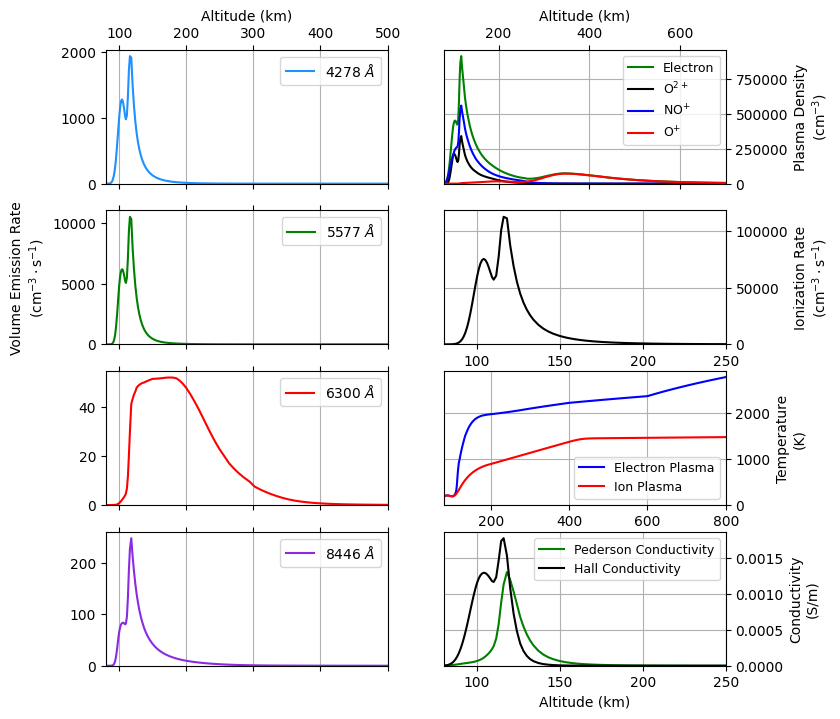

In [6]:
# print the energy flux, characteristic energy, and oxygen correction factor
print("Energy Flux:                %.03f erg/cm2/s" % (result.energy_flux))
print("Characteristic Energy:      %.03f eV" % (result.characteristic_energy))
print("Oxygen Correction Factor:   %.03f\n" % (result.oxygen_correction_factor))

# print all height-integrated Rayleighs data
print("""Height-integrated Rayleighs:
  427.8nm:  %.02f R
  557.7nm:  %.02f R
  630.0nm:  %.02f R
  844.6nm:  %.02f R""" % (result.height_integrated_rayleighs_4278,
                          result.height_integrated_rayleighs_5577,
                          result.height_integrated_rayleighs_6300,
                          result.height_integrated_rayleighs_8446))

# plot the emission, plasma, and neutral data
#
# we'll do this all in one plot, but made up from many subplots
alt = result.altitudes
fig = plt.figure(figsize=(8,8))

# plot all the emissions as a column of subplots
# 
# blueline emission
ax1 = fig.add_subplot(4,2,1)
ax1.plot(alt, result.emission_4278, label=r"4278 $\AA$", color="dodgerblue")
ax1.legend()
ax1.set_xlim(80,500)
ax1.set_ylim(bottom=0)
ax1.grid(axis="x")
ax1.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax1.xaxis.set_label_position("top")
ax1.set_xlabel("Altitude (km)")
ax1.xaxis.set_label_position("top")

# greenline emission
ax2 = fig.add_subplot(4,2,3)
ax2.plot(alt, result.emission_5577, label=r"5577 $\AA$", color="green")
ax2.legend()
ax2.set_xlim(80,500)
ax2.set_ylim(bottom=0)
ax2.grid(axis="x")
ax2.set_ylabel("Volume Emission Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# redline emission
ax3 = fig.add_subplot(4,2,5)
ax3.plot(alt, result.emission_6300, label=r"6300 $\AA$", color="red")
ax3.legend()
ax3.set_xlim(80,500)
ax3.set_ylim(bottom=0)
ax3.grid(axis="x")
ax3.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# near-infrared 8446 A emission
ax4 = fig.add_subplot(4,2,7)
ax4.plot(alt, result.emission_8446, label=r"8446 $\AA$", color="blueviolet")
ax4.legend()
ax4.set_xlim(80,500)
ax4.set_ylim(bottom=0)
ax4.grid(axis="x")
ax4.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# plot the plasma data as a second column of subplots
#
# plasma density
ax5 = fig.add_subplot(4,2,2)
ax5.plot(alt, result.plasma_electron_density, label="Electron", color="green")
ax5.plot(alt, result.plasma_o2plus_density, label="O$^{2+}$", color="black")
ax5.plot(alt, result.plasma_noplus_density, label="NO$^{+}$", color="blue")
ax5.plot(alt, result.plasma_oplus_density, label="O$^{+}$", color="red")
ax5.grid()
ax5.set_ylabel("Plasma Density\n(cm$^{-3}$)")
ax5.legend(fontsize=9)
ax5.set_xlim(80,700)
ax5.set_ylim(bottom=0)
ax5.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax5.set_xlabel("Altitude (km)")
ax5.xaxis.set_label_position("top")
ax5.yaxis.set_label_position("right")
ax5.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma ionisation rate
ax6 = fig.add_subplot(4,2,4)
ax6.plot(alt, result.plasma_ionisation_rate, color="black")
ax6.grid()
ax6.set_ylabel("Ionization Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax6.set_xlim(80,250)
ax6.set_ylim(bottom=0)
ax6.yaxis.set_label_position("right")
ax6.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma temperatures
ax7 = fig.add_subplot(4,2,6)
ax7.plot(alt, result.plasma_electron_temperature, label="Electron Plasma", color="blue")
ax7.plot(alt, result.plasma_ion_temperature, label="Ion Plasma", color="red")
ax7.grid()
ax7.legend(fontsize=9)
ax7.set_ylabel("Temperature\n(K)")
ax7.set_xlim(80,800)
ax7.set_ylim(bottom=0)
ax7.yaxis.set_label_position("right")
ax7.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma conductivities
ax8 = fig.add_subplot(4,2,8)
ax8.plot(alt, result.plasma_pederson_conductivity, label="Pederson Conductivity", color="green")
ax8.plot(alt, result.plasma_hall_conductivity, label="Hall Conductivity", color="black")
ax8.grid()
ax8.legend(fontsize=9)
ax8.set_ylabel("Conductivity\n(S/m)")
ax8.set_xlim(80,250)
ax8.set_ylim(bottom=0)
ax8.set_xlabel("Altitude (km)")
ax8.yaxis.set_label_position("right")
ax8.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# render the plot
plt.show()